# Preprocessing Phase

In [82]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]    | 

KeyboardInterrupt: 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string as st
import re
from nltk import PorterStemmer, WordNetLemmatizer

# Input data files are available in the read-only "./input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Read the data. Here it is already in .csv format.
train_data = pd.read_csv('dataset/BBC News Train.csv')
test_data = pd.read_csv('dataset/BBC News Test.csv')
data = pd.concat([train_data,test_data])
data.to_csv('dataset/data.csv', index=False)
data.head(10)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [ ]:
data.shape

(2225, 3)

# Text cleaning and processing steps
* Remove punctuations
* Convert text to tokens
* Remove tokens of length less than or equal to 3
* Remove stopwords using NLTK corpus stopwords list to match
* Apply lemmatization
* Convert words to feature vectors

In [ ]:
# Remove all punctuations from the text

def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

In [ ]:
data['removed_punc'] = data['Text'].apply(lambda x: remove_punct(x))
data.head()

In [ ]:
''' Convert text to lower case tokens. Here, split() is applied on white-spaces. But, it could be applied
    on special characters, tabs or any other string based on which text is to be seperated into tokens.
'''
def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

In [ ]:
data['tokens'] = data['removed_punc'].apply(lambda msg : tokenize(msg))
data.head()

In [ ]:
# Remove tokens of length less than 3

def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

In [ ]:
data['larger_tokens'] = data['tokens'].apply(lambda x : remove_small_words(x))
data.head()

In [ ]:
''' Remove stopwords. Here, NLTK corpus list is used for a match. However, a customized user-defined 
    list could be created and used to limit the matches in input text. 
'''
def remove_stopwords(text):
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]

In [ ]:
data['clean_tokens'] = data['larger_tokens'].apply(lambda x : remove_stopwords(x))
data.head()

In [ ]:
# Apply lemmatization on tokens
def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

In [ ]:
data['lemma_words'] = data['clean_tokens'].apply(lambda x : lemmatize(x))
data.head()

In [ ]:
# Create sentences to get clean text as input for vectors

def return_sentences(tokens):
    return " ".join([word for word in tokens])

In [ ]:
data['clean_text'] = data['lemma_words'].apply(lambda x : return_sentences(x))
data.head()


# Model and Evaluation Phase

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.utils import resample

def balance_data(data, category_col):
    categories = data[category_col].unique()
    min_category_count = data[category_col].value_counts().min()

    balanced_data = []

    for category in categories:
        category_data = data[data[category_col] == category]
        category_data_balanced = resample(category_data, replace=False, n_samples=min_category_count, random_state=42)
        balanced_data.append(category_data_balanced)

    return pd.concat(balanced_data)


In [ ]:
balanced_data = balance_data(data, 'Category')
X_train, X_test, y_train, y_test = train_test_split(balanced_data['clean_text'], balanced_data['Category'], test_size=0.2, random_state=42)

In [ ]:
y_train_counts = y_train.value_counts()
print("Category counts in the training set:")
print(y_train_counts)

y_test_counts = y_test.value_counts()
print("\nCategory counts in the testing set:")
print(y_test_counts)



Category counts in the training set:
politics         334
sport            326
tech             326
entertainment    325
business         321
Name: Category, dtype: int64

Category counts in the testing set:
business         87
entertainment    83
sport            82
tech             82
politics         74
Name: Category, dtype: int64


In [ ]:
#vectorizer = CountVectorizer()
#X_train_vec = vectorizer.fit_transform(X_train)
#X_test_vec = vectorizer.transform(X_test)

# OR

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=5)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [95]:
categories = y_train.unique()
category_avg_vecs = {}

for category in categories:
    category_indices = y_train[y_train == category].index
    category_vectors = X_train_vec[category_indices, :]
    category_avg_vec = np.mean(category_vectors, axis=0)
    category_avg_vecs[category] = category_avg_vec


In [98]:
from sklearn.metrics.pairwise import cosine_similarity

def predict_category(text, vectorizer, category_avg_vecs):
    text_vec = vectorizer.transform([text])
    max_similarity = -1
    predicted_category = None

    for category, avg_vec in category_avg_vecs.items():
        similarity = cosine_similarity(text_vec, np.asarray(avg_vec)) # Convert avg_vec to a numpy array
        if similarity > max_similarity:
            max_similarity = similarity
            predicted_category = category

    return predicted_category



In [99]:
y_pred = [predict_category(text, vectorizer, category_avg_vecs) for text in X_test]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy: 0.3113
Classification Report:
                precision    recall  f1-score   support

     business       0.43      0.46      0.45        87
entertainment       0.29      0.31      0.30        83
     politics       0.31      0.35      0.33        74
        sport       0.29      0.27      0.28        82
         tech       0.19      0.16      0.17        82

     accuracy                           0.31       408
    macro avg       0.30      0.31      0.31       408
 weighted avg       0.31      0.31      0.31       408

Confusion Matrix:
 [[40  8 21  5 13]
 [13 26 11 29  4]
 [15 19 26  8  6]
 [ 4 17  6 22 33]
 [20 19 19 11 13]]


In [ ]:
def train_and_evaluate(classifier, X_train_vec, y_train, X_test_vec, y_test):
    classifier.fit(X_train_vec, y_train)
    y_pred = classifier.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    print(classifier.__class__.__name__)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")
    
    performance = {
        "accuracy": accuracy,
        "precision": classification_report_dict["macro avg"]["precision"],
        "recall": classification_report_dict["macro avg"]["recall"],
        "f1_score": classification_report_dict["macro avg"]["f1-score"],
    }
    
    return performance

In [ ]:
performance_metrics = {}

classifiers = [
    MultinomialNB(),
    LogisticRegression(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier()
]


for classifier in classifiers:
    performance_metrics[classifier.__class__.__name__] = train_and_evaluate(classifier, X_train_vec, y_train, X_test_vec, y_test)


MultinomialNB
Accuracy: 0.7426470588235294
Classification Report:
                precision    recall  f1-score   support

     business       0.78      0.80      0.79        87
entertainment       0.86      0.73      0.79        83
     politics       0.68      0.73      0.70        74
        sport       0.70      0.80      0.75        82
         tech       0.71      0.63      0.67        82

     accuracy                           0.74       408
    macro avg       0.75      0.74      0.74       408
 weighted avg       0.75      0.74      0.74       408

Confusion Matrix:
 [[70  1  7  6  3]
 [ 4 61  5  6  7]
 [ 4  4 54  6  6]
 [ 4  2  5 66  5]
 [ 8  3  9 10 52]]


LogisticRegression
Accuracy: 0.7352941176470589
Classification Report:
                precision    recall  f1-score   support

     business       0.77      0.79      0.78        87
entertainment       0.84      0.75      0.79        83
     politics       0.67      0.72      0.69        74
        sport       0.70      

In [ ]:
for classifier, metrics in performance_metrics.items():
    print(f"{classifier}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print("\n")


MultinomialNB:
  accuracy: 0.7426
  precision: 0.7453
  recall: 0.7417
  f1_score: 0.7411


LogisticRegression:
  accuracy: 0.7353
  precision: 0.7363
  recall: 0.7342
  f1_score: 0.7332


LinearSVC:
  accuracy: 0.6912
  precision: 0.6932
  recall: 0.6900
  f1_score: 0.6889


RandomForestClassifier:
  accuracy: 0.7157
  precision: 0.7165
  recall: 0.7138
  f1_score: 0.7131


KNeighborsClassifier:
  accuracy: 0.6765
  precision: 0.6775
  recall: 0.6754
  f1_score: 0.6739




In [ ]:
from sklearn.model_selection import cross_val_score

def evaluate_with_cross_val(classifier, X, y, n_splits=5):
    scores = cross_val_score(classifier, X, y, cv=n_splits)
    return np.mean(scores)

X_vec = vectorizer.fit_transform(data['clean_text'])
y = data['Category']

for classifier in classifiers:
    mean_score = evaluate_with_cross_val(classifier, X_vec, y)
    print(f"{classifier.__class__.__name__}: {mean_score:.4f}")


MultinomialNB: 0.7151
LogisticRegression: 0.7029
LinearSVC: 0.6440
RandomForestClassifier: 0.6751
KNeighborsClassifier: 0.6247


Confusion Matrix for MultinomialNB:


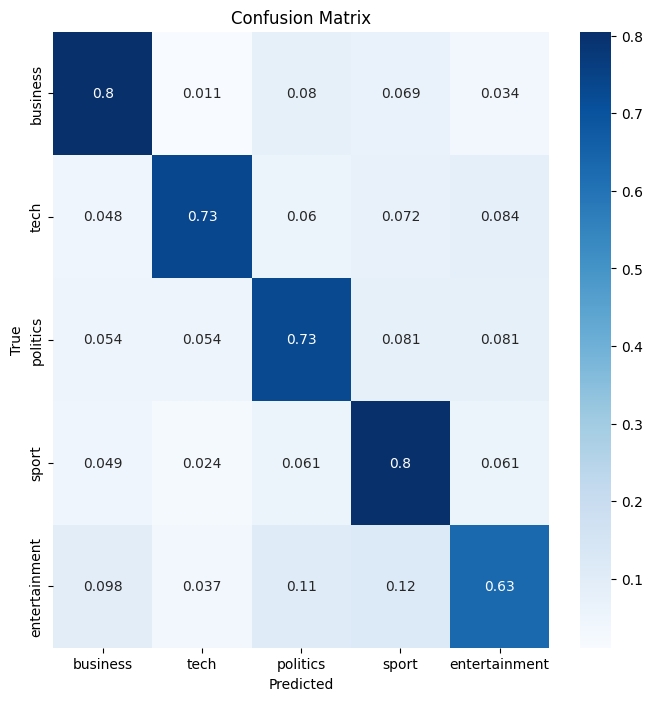

Confusion Matrix for LogisticRegression:


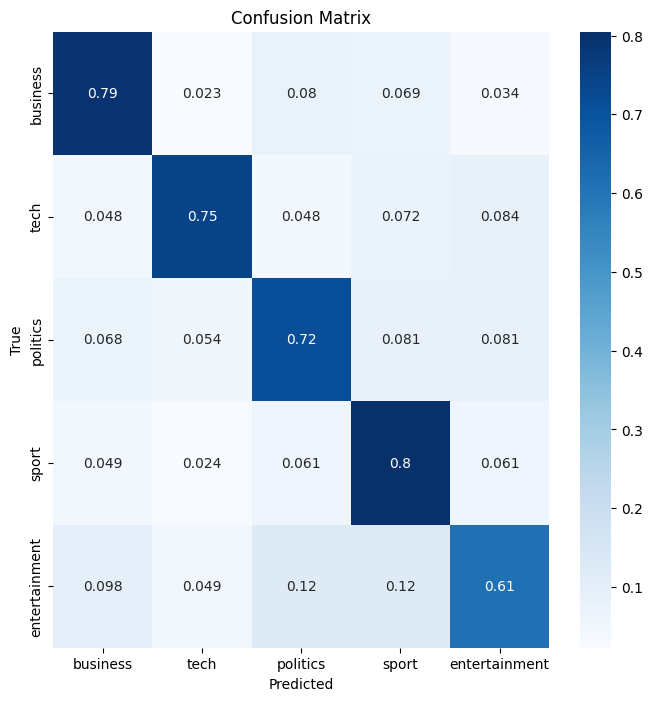

Confusion Matrix for LinearSVC:


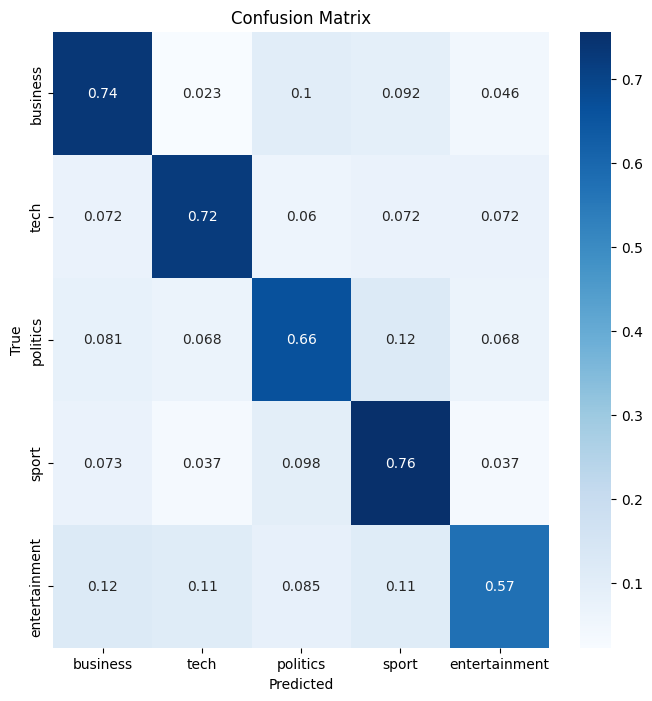

Confusion Matrix for RandomForestClassifier:


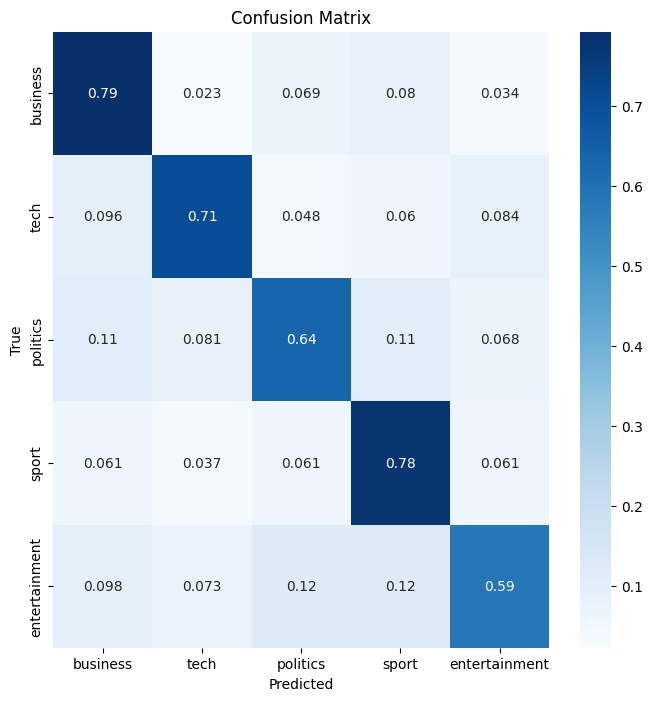

Confusion Matrix for KNeighborsClassifier:


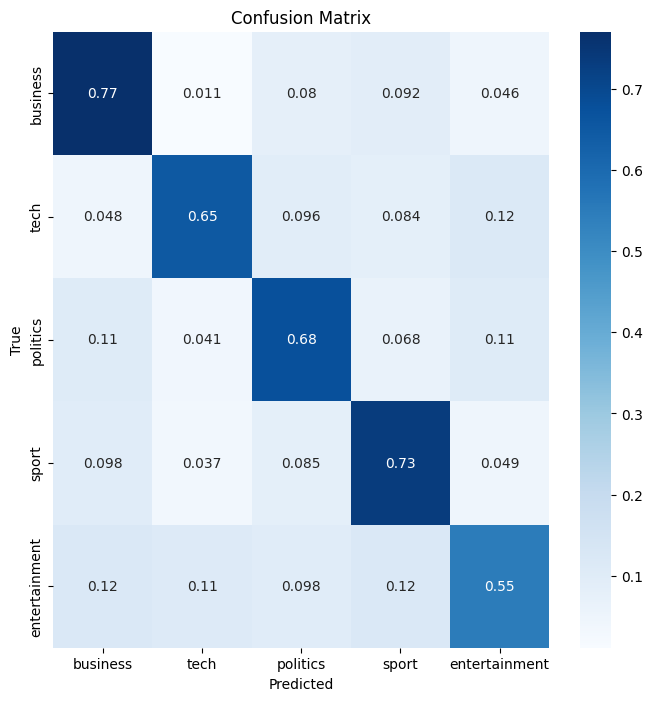

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = data['Category'].unique()

for classifier in classifiers:
    classifier.fit(X_train_vec, y_train)
    y_pred = classifier.predict(X_test_vec)
    print(f"Confusion Matrix for {classifier.__class__.__name__}:")
    plot_cm(y_test, y_pred, class_names)


